# Example embeddings

This file is a meant to produce a visualization of NLP methods using the following lexical ressources:

- Bert embeddings
- WordNet knowledge base

The idea is to find full-sentence input containing words that pertain to distinct categories, to obtain BERT embeddings of these sentences, and then to project the embeddings onto a 2-dimensional space 


In [9]:
import pandas as pd
import numpy as np
## import packages for general NLP
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag, map_tag, pos_tag_sents
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer


from collections import Counter
import pickle
from string import punctuation
from ast import literal_eval
import sys

# embeddings
from transformers import BertModel, BertTokenizer
import torch

## visuals
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


# Download model and lemmatizer

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [11]:
LEMMATIZER = WordNetLemmatizer()

# Find sentence realizations containing lemmas pertaining to distinct categories of hypernyms

In [12]:
def wn_pos(treebank_tag):
    """Method adapted from various stackoverflow posts
    
    https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
    
    
    :param treebank_tag: the string of the english ptb pos tag
    
    :return:
      the wordnet postag object 
    """
    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def lemmatize_sent(sent):
    """Function returning lemmas and tokens of sentence via wordnet lemmatizer
    
    """
    
    return [(LEMMATIZER.lemmatize(tok.lower(), pos = wn_pos(pos)), tok) 
            if wn_pos(pos) and tok not in punctuation else ('', tok)
           for tok, pos in pos_tag(word_tokenize(sent))]


def get_hyponyms(hyper_syns, lemma_names, hypos):
    """Recursive method to extend list of lemmas of hyponyms from the given hypernym
    
    
    There is a possible way to do a closure operation using built in tree() function
    but this would not allow us to append all of the lemmas
    
    :params: 
        hyper_syns: wordnet synset object of the hypernym
        lemma_names: list of lemmas to be extended
        hypos: list of hyponyms to be extended    
    
    """
    for hypo in hyper_syns.hyponyms():
        hypos.append(hypo)
        lemma_names.extend(hypo.lemma_names())
        get_hyponyms(hypo, lemma_names, hypos)
    





def get_sents():
    """Method returning sentences which contain lemmas pertaining to distinct categories of hypernyms
    
    :return:
        sentences_to_encode: a dictionary with the sentence, the hyponyms index within the sentence, and the hypernym category
            
    
    """
    
    sentences_to_encode = dict()
    hypers_to_plot = ['diversion.n.01', 'wrongdoing.n.02', 'mistreatment.n.01', 'travel.n.01', 'vehicle.n.01']
    category2index = {'diversion.n.01' : 1, 
                      'wrongdoing.n.02': 2, 
                      'mistreatment.n.01': 2, 
                      'travel.n.01': 3, 
                      'vehicle.n.01': 4
                     }
    for hyper in hypers_to_plot:
        syns = wn.synset(hyper)
        lemma_names = []
        hypos = []
        get_hyponyms(syns, lemma_names, hypos) 
        for hypo in hypos:
            examples = hypo.examples()
            if examples:
                for example in examples:
                    if example:
                        lemma_tokenized = lemmatize_sent(example)
                        lemmatized_sent = [x[0] for x in lemma_tokenized]
                        tokenized_sent = [x[1] for x in lemma_tokenized]
                        for lemma in lemma_names:
                            if lemma in lemmatized_sent:
                                sentences_to_encode[lemma] = {
                                    "sentence" : ' '.join(tokenized_sent),
                                    "position" : lemmatized_sent.index(lemma),
                                    "hyper_cat" : category2index[hyper]
                                }
    return sentences_to_encode

In [13]:
sentences = get_sents()
print("The above method succeeded in collecting ", len(sentences), "sentences from Wordnet.", '\n\n')

print("An example of the data collected is as follows:")
sentences['sport']

The above method succeeded in collecting  160 sentences from Wordnet. 


An example of the data collected is as follows:


{'sentence': 'baseball is a team sport by golf is not',
 'position': 4,
 'hyper_cat': 1}

# Embed sentences with indexed highlighted words

In [14]:
all_embed = []
all_labels = []
with torch.no_grad():
    for sent in sentences:
        input_ids = torch.tensor(tokenizer.encode(sentences[sent]['sentence'])).unsqueeze(0) 
        outputs = model(input_ids)
        last_hidden_states = outputs[0].squeeze()
        embed = last_hidden_states.detach().tolist()
        labels = np.zeros(len(embed))
        toks = [tokenizer.convert_ids_to_tokens(idx) for idx in input_ids]
        if sentences[sent]['sentence'].split()[sentences[sent]['position']] in toks[0]:
            new_index = toks[0].index(sentences[sent]['sentence'].split()[sentences[sent]['position']])
            labels[new_index] = sentences[sent]['hyper_cat']
        all_embed.extend(embed)
        all_labels.extend(labels)

# Plot

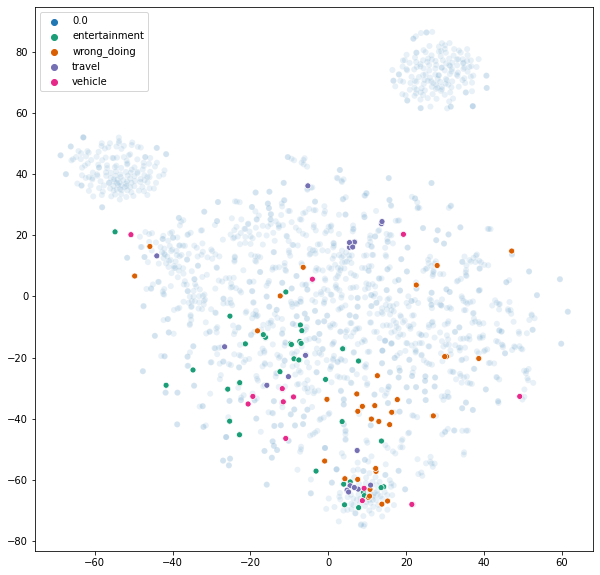

In [17]:
index2category = {1: "entertainment", 2: "wrong_doing", 3: "travel", 4: "vehicle"}
RS = 25111993
fig = plt.figure(figsize = (10, 10))
tnse = TSNE(random_state = RS, n_components =2).fit_transform(all_embed)
x_0 = [x[0] for x, l in zip(tnse, all_labels) if not l]
y_0 = [x[1] for x, l in zip(tnse, all_labels) if not l]
all_labels_0 = [x for x in all_labels if not x]
ax = sns.scatterplot(x_0, y_0, hue = all_labels_0, alpha = 0.1, legend = "full", palette = sns.color_palette(n_colors = 1))
x_123 = [x[0] for x, l in zip(tnse, all_labels) if l]
y_123 = [x[1] for x, l in zip(tnse, all_labels) if l]
all_labels_123 = [index2category[x] for x in all_labels if x]
ax = sns.scatterplot(x_123, y_123, hue = all_labels_123, palette = sns.color_palette("Dark2", n_colors=len([x for x in index2category])),legend = "full")